In [1]:
%matplotlib inline

from glob import glob
from pprint import pprint
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

"Ready"

'Ready'

In [2]:
def iter_metrics(globspec="metrics/metrics_*.json"):
    for p in glob(globspec):
        with open(p) as fp:
            yield json.load(fp)

In [3]:
"Found %d metrics files" % sum(1 for x in iter_metrics())

'Found 21 metrics files'

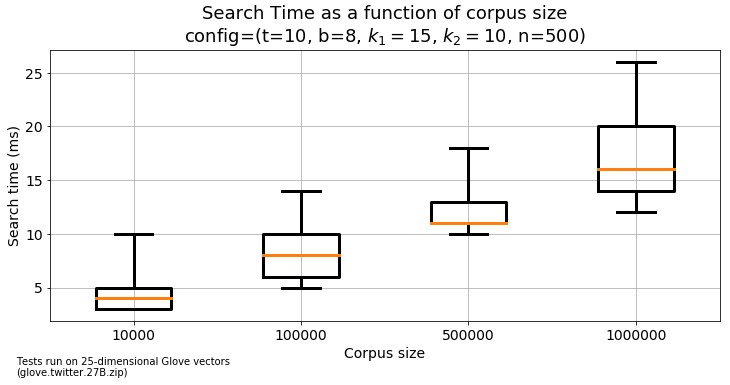

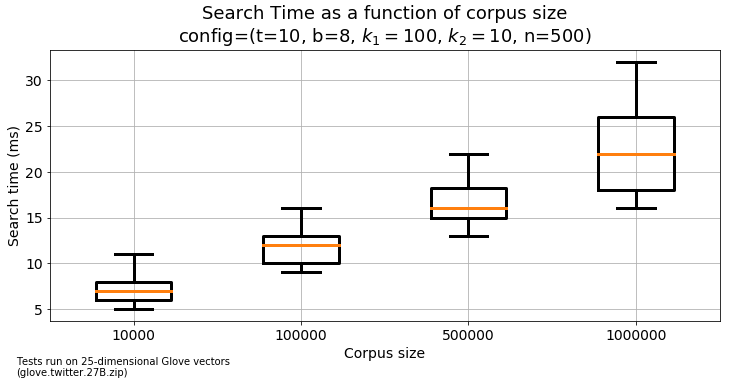

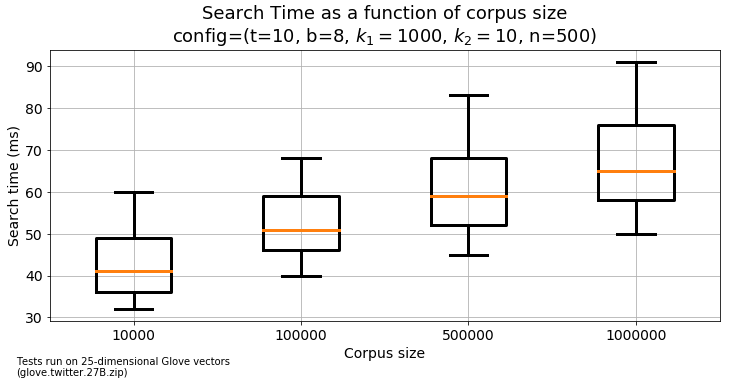

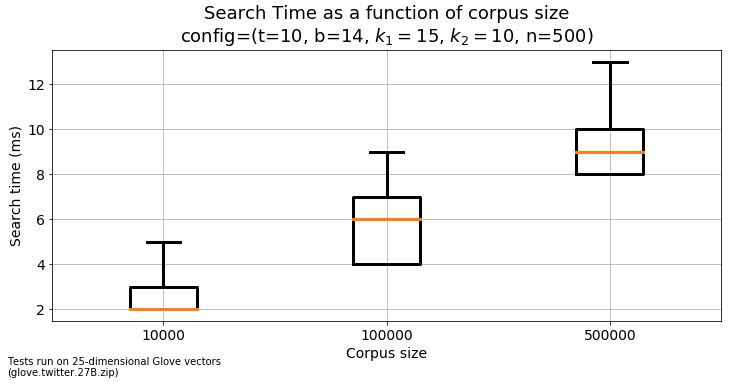

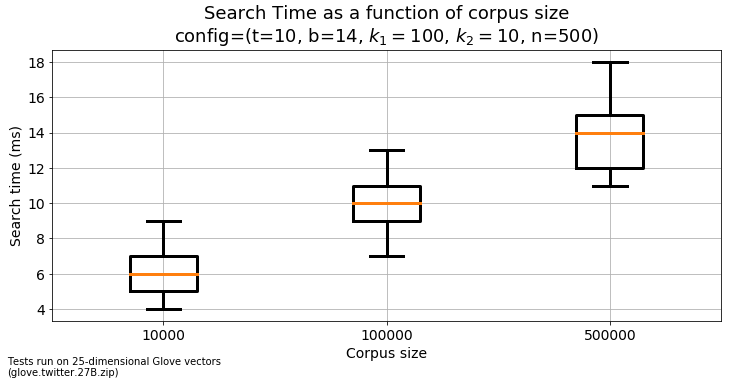

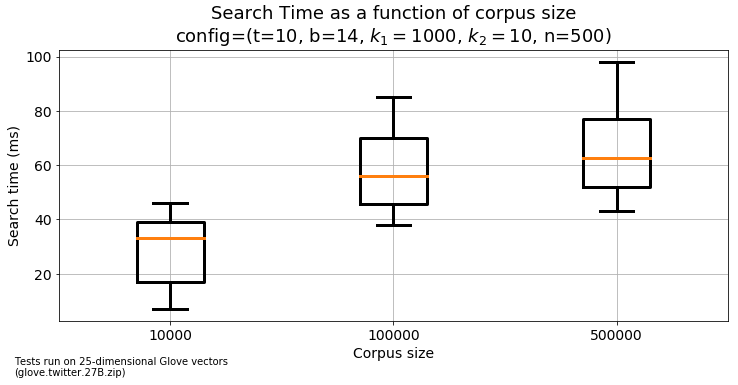

In [4]:
# Plot the search times as a function of corpus size.
df = pd.DataFrame(list(iter_metrics()))

for key, df_ in df.groupby(["nb_tables", "nb_bits", "k1", "k2"]):
    df_ = df_.sort_values("nb_docs", ascending=True)
    
    # Boxplot...
    bpdata = df_.search_times.values
    plt.figure(figsize=(12, 5))
    plt.boxplot(bpdata, showfliers=False, 
                whis=[5, 95],
                boxprops={"linewidth": 3},
                medianprops={"linewidth": 3},
                whiskerprops={"linewidth": 3},
                capprops={"linewidth": 3})
    plt.xticks(range(1, len(bpdata) + 1), df_.nb_docs.values, size=14)
    plt.yticks(size=14)
    plt.title("Search Time as a function of corpus size\nconfig=(t=%d, b=%d, $k_1=%d$, $k_2=%d$, n=%d)" % (
        *key, len(bpdata[0])), size=18)
    plt.xlabel("Corpus size", size=14)
    plt.ylabel("Search time (ms)", size=14)
    plt.grid(True)
    
    y0, y1 = plt.gca().get_ylim()
    h = y1 - y0
    plt.text(0.3, y0 - (h * 0.2), 
             "Tests run on 25-dimensional Glove vectors \n(glove.twitter.27B.zip)")
    plt.show()

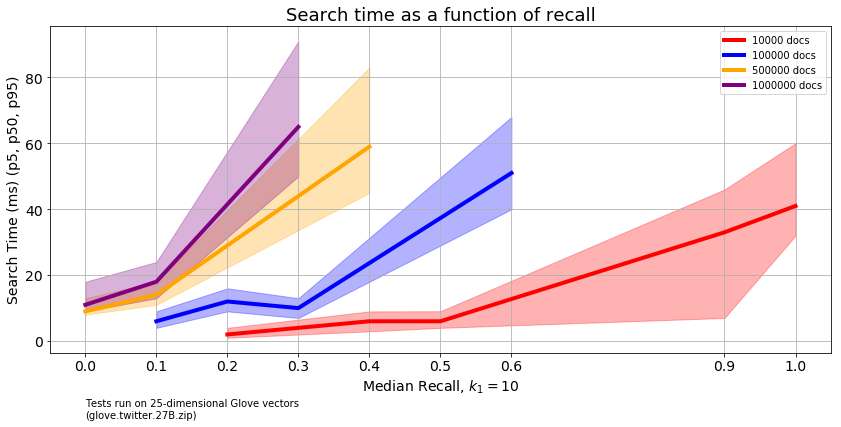

In [8]:
# Plot speed/recall frontier.
# This is the point with the lowest median search time for every unique median IOU, grouped by corpus size.

plt.figure(figsize=(14, 6))
rows = []
for row in iter_metrics():
    row["reca50"] = np.median(row["search_recalls"])
    row["time50"] = np.median(row["search_times"])
    rows.append(row)

df = pd.DataFrame(rows)

xticks = set([])

colors = iter(["red", "blue", "orange", "purple", "cyan"])

for nb_docs, df_ in df.groupby(["nb_docs"]):
    X, Y0, YM, Y1 = [], [], [], []
    for iou50, df_ in df_.groupby(["reca50"]):
        df_ = df_.sort_values("time50", ascending=True)
        _, r = next(df_.iterrows())
        X.append(iou50)
        YM.append(r.time50)
        Y0.append(np.percentile(r.search_times, 5))
        Y1.append(np.percentile(r.search_times, 95))
        xticks.add(round(X[-1], 1))
    c = next(colors)    
    plt.fill_between(X, Y0, Y1, alpha=0.3, color=c)
    plt.plot(X, YM, label="%d docs" % nb_docs, linewidth=4, color=c)
plt.legend()
plt.title("Search time as a function of recall", size=18)
plt.ylabel("Search Time (ms) (p5, p50, p95)", size=14)
plt.xlabel("Median Recall, $k_1=10$", size=14)
plt.yticks(size=14)
plt.xticks(sorted(list(xticks)), sorted(list(xticks)), size=14)
y0, y1 = plt.gca().get_ylim()
h = y1 - y0
plt.text(0.0, y0 - (h * 0.2), 
         "Tests run on 25-dimensional Glove vectors \n(glove.twitter.27B.zip)")
plt.grid(True)
plt.show()